In [1]:
print('hi')

hi


In [2]:
import os
# select cuda 0
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

if cuda_available:
    # Number of GPUs
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs:", num_gpus)

    # List each device’s name
    for i in range(num_gpus):
        name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {name}")
else:
    print("No CUDA devices found")

CUDA available: True
Number of GPUs: 1
GPU 0: Tesla V100-PCIE-32GB


In [3]:
from buffer import DiscBuffer

buffer = DiscBuffer('/var/local/glang/activations/clt-activations-10M.h5', 'tensor')

loader = torch.utils.data.DataLoader(
    buffer,
    num_workers=1,
 #   prefetch_factor=10,
    batch_size=1000,
    shuffle=True,
    persistent_workers=True,
)
test_loader = torch.utils.data.DataLoader(
    buffer,
    num_workers=1,
    #prefetch_factor=10,
    batch_size=1000,
    shuffle=True,
    persistent_workers=True,
)

In [5]:
from tqdm import tqdm

# ------- rest of the cell is unchanged ------------------------------
import itertools, time, torch, pandas as pd
from buffer import DiscBuffer

DATA_PATH   = "/var/local/glang/activations/clt-activations-10M.h5"
BATCH_SIZE  = 1_000
N_BATCHES   = 30
WARMUP      = 3

NUM_WORKERS       = [0, 1, 2, 4, 8, 16, 32]
PREFETCH_FACTOR   = [2, 4, 8, 16]
PERSISTENT        = [False, True]
PIN_MEMORY        = [False, True]

def bench_once(num_workers, pff, persistent, pin_memory):
    if num_workers == 0 and pff is not None:         # skip: illegal combo
        return {
            "num_workers": num_workers,
            "prefetch_factor": pff,
            "persistent": persistent,
            "pin_memory": pin_memory,
            "items_per_sec": 0,
            "ms_per_batch": 0,
        }
    ds = DiscBuffer(DATA_PATH, "tensor")
    loader = torch.utils.data.DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        prefetch_factor=pff,
        persistent_workers=persistent,
        shuffle=True,
        pin_memory=pin_memory,
    )
    it = iter(loader)
    for _ in range(WARMUP):
        next(it)

    t0, n_items = time.perf_counter(), 0
    for _ in range(N_BATCHES):
        batch = next(it)
        if isinstance(batch, torch.Tensor):
            n_items += batch.size(0)
        elif isinstance(batch, (list, tuple)):
            n_items += batch[0].size(0)
        else:                              # dict or other mapping
            n_items += next(iter(batch.values())).size(0)

    dt = time.perf_counter() - t0
    return {
        "num_workers": num_workers,
        "prefetch_factor": pff,
        "persistent": persistent,
        "pin_memory": pin_memory,
        "items_per_sec": n_items / dt,
        "ms_per_batch": 1_000 * dt / N_BATCHES,
    }

grid = list(itertools.product(NUM_WORKERS, PREFETCH_FACTOR, PERSISTENT, PIN_MEMORY))
results = [bench_once(*cfg) for cfg in tqdm(grid, desc="benchmarking")]

df = pd.DataFrame(results).sort_values("items_per_sec", ascending=False)
display(df.style.format({"items_per_sec": "{:.0f}", "ms_per_batch": "{:.2f}"}))




benchmarking: 100%|██████████| 112/112 [09:09<00:00,  4.91s/it]


,num_workers,prefetch_factor,persistent,pin_memory,items_per_sec,ms_per_batch
99,32,2,True,True,276587,3.62
103,32,4,True,True,189883,5.27
108,32,16,False,False,100665,9.93
106,32,8,True,False,88238,11.33
90,16,8,True,False,83665,11.95
104,32,8,False,False,83528,11.97
94,16,16,True,False,82362,12.14
100,32,4,False,False,76101,13.14
96,32,2,False,False,72027,13.88
86,16,4,True,False,70762,14.13


In [ ]:
from lightning.pytorch.loggers import WandbLogger
from clt import CrossLayerTranscoder
import lightning.pytorch as L
from jumprelu import JumpReLU


logger = WandbLogger(project='wandb_clt')
trainer = L.Trainer(logger=logger, max_steps=2000, limit_train_batches=2000, 
                    val_check_interval=10, limit_val_batches=1,
                    check_val_every_n_epoch=None, 
                    enable_checkpointing=False,
                    )
trainer.fit(
    model=CrossLayerTranscoder(config={
        "d_acts": 768,
        "d_features": 768 * 8,
        "n_layers": 12,
        "lambda": 0.0002,
        "c": 0.1,
        "lr": 1e-3
    }, nonlinearity=JumpReLU(theta=0.03, bandwidth=1., n_layers=12, d_features=768 * 8)),
    train_dataloaders=loader,
    val_dataloaders=test_loader,
)

# Save checkpoint after training
checkpoint_path = "checkpoints/clt.ckpt"
trainer.save_checkpoint(checkpoint_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


Token indices sequence length is longer than the specified maximum sequence length for this model (1561 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1217 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2459 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2027 > 1024). Running this sequence through the model will result in indexing errors
wandb: Currently logged in as: georglange to https://api.wandb.ai. Use `wandb lo

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name              | Type                     | Params | Mode 
-----------------------------------------------------------------------
0 | nonlinearity      | JumpReLU                 | 73.7 K | train
1 | replacement_model | ReplacementModelAccuracy | 0      | train
  | other params      | n/a                      | 736 M  | n/a  
-----------------------------------------------------------------------
736 M     Trainable params
0         Non-trainable params
736 M     Total params
2,944.696 Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/var/metrics/g/crosslayer-transcoder/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/var/metrics/g/crosslayer-transcoder/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]computing replacement model 0


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


computing replacement model 1
computing replacement model 2
computing replacement model 3
computing replacement model 4
computing replacement model 5
computing replacement model 6
computing replacement model 7
computing replacement model 8
computing replacement model 9
computing replacement model 10
computing replacement model 11
exiting update
exiting val epoch end


/var/metrics/g/crosslayer-transcoder/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=191` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 10/2000 [00:06<22:16,  1.49it/s, v_num=2v7m]computing replacement model 0
computing replacement model 1
computing replacement model 2
computing replacement model 3
computing replacement model 4
computing replacement model 5
computing replacement model 6
computing replacement model 7
computing replacement model 8
computing replacement model 9
computing replacement model 10
computing replacement model 11
exiting update
exiting val epoch end
Epoch 0:   1%|          | 20/2000 [00:21<36:12,  0.91it/s, v_num=2v7m]computing replacement model 0
computing replacement model 1
computing replacement model 2
computing replacement model 3
computing replacement model 4
computing replacement model 5
computing replacement model 6
computing replacement model 7
computing replacement model 8
computing replacement model 9
computing replacement model 10
computing replacement model 11
exiting update
exiting val epoch end
Epoch 0:   2%|▏         | 30/2000 [00:36<40:29,  0.81it/s, v_n


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [4]:
# load the saved model
import torch




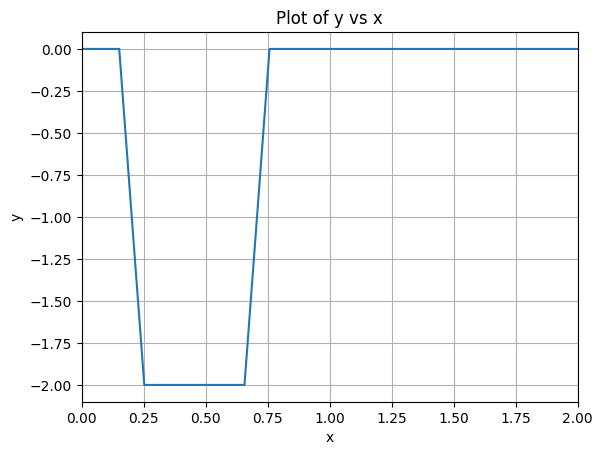

In [ ]:
def K(x):
    return H(x + .5) - H(x - .5)

def H(x):
    return np.where(x > 0, np.ones_like(x), np.zeros_like(x))

def derivative(x):
    e = .5
    theta = .5
    return (-1/e) * K((x - theta) / e)

import matplotlib.pyplot as plt
import numpy as np

def plot(x, y):
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot of y vs x')
    plt.grid()
    plt.xlim(0, 2)
    plt.show()

x = np.linspace(-5, 5, 100)
y = derivative(x)
plot(x, y)


In [ ]:
(batchsize nlayer dfeature), (nlayer dfeatures dacts) -> (batchsize nlayer dacts)


batch tolayer dacts = 

for n in fromlayer:
    for f in dfeatures:
        add acts[batch nlayers f] * W_dec[n tolayer f dacts] * mask[fromlayer tolayer]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3602769960.py, line 1)

In [ ]:
t = torch.triu(torch.ones(12, 12))
t[0, 6] = 6
t

tensor([[1., 1., 1., 1., 1., 1., 6., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
import torch

a = torch.randint(0, 10, (3, 4))
b = torch.randint(0, 10, (4, 5))
a, b

(tensor([[3, 1, 1, 7],
         [3, 6, 0, 1],
         [5, 7, 6, 2]]),
 tensor([[7, 2, 3, 1, 0],
         [3, 9, 7, 2, 6],
         [9, 4, 5, 3, 0],
         [8, 6, 3, 9, 8]]))

In [ ]:
from einops import einsum

einsum(a, b, 'a b, c d -> a b d')

tensor([[[ 81,  63,  54,  45,  42],
         [ 27,  21,  18,  15,  14],
         [ 27,  21,  18,  15,  14],
         [189, 147, 126, 105,  98]],

        [[ 81,  63,  54,  45,  42],
         [162, 126, 108,  90,  84],
         [  0,   0,   0,   0,   0],
         [ 27,  21,  18,  15,  14]],

        [[135, 105,  90,  75,  70],
         [189, 147, 126, 105,  98],
         [162, 126, 108,  90,  84],
         [ 54,  42,  36,  30,  28]]])

res[a b d] = 
    for j in range(c):
        add a[a, b] * b[c, d]

In [ ]:
torch.tril(torch.ones(12, 12))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
# make two small example tensors
x = torch.randn(2, 4, 3)
y = torch.ones(3, 4) * 2
x, y

(tensor([[[ 0.1049,  0.6891, -0.2221],
          [-0.6869, -1.8075,  1.1821],
          [ 1.9893, -0.8786,  1.2487],
          [ 0.9046,  0.4721, -0.8072]],
 
         [[ 0.4983,  0.7082,  0.0465],
          [ 0.3724,  0.8592, -0.3992],
          [-0.5043,  0.9919, -1.5528],
          [-1.2314, -0.1028,  0.0340]]]),
 tensor([[2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.]]))

In [ ]:
x @ y

tensor([[[ 1.1438,  1.1438,  1.1438,  1.1438],
         [-2.6246, -2.6246, -2.6246, -2.6246],
         [ 4.7188,  4.7188,  4.7188,  4.7188],
         [ 1.1390,  1.1390,  1.1390,  1.1390]],

        [[ 2.5060,  2.5060,  2.5060,  2.5060],
         [ 1.6648,  1.6648,  1.6648,  1.6648],
         [-2.1303, -2.1303, -2.1303, -2.1303],
         [-2.6004, -2.6004, -2.6004, -2.6004]]])

In [ ]:
torch.matmul(x, y)

tensor([[[ 1.1438,  1.1438,  1.1438,  1.1438],
         [-2.6246, -2.6246, -2.6246, -2.6246],
         [ 4.7188,  4.7188,  4.7188,  4.7188],
         [ 1.1390,  1.1390,  1.1390,  1.1390]],

        [[ 2.5060,  2.5060,  2.5060,  2.5060],
         [ 1.6648,  1.6648,  1.6648,  1.6648],
         [-2.1303, -2.1303, -2.1303, -2.1303],
         [-2.6004, -2.6004, -2.6004, -2.6004]]])

In [ ]:
from einops import einsum

einsum(x, y, 'a b c, c d -> a b d')

tensor([[[ 1.1438,  1.1438,  1.1438,  1.1438],
         [-2.6246, -2.6246, -2.6246, -2.6246],
         [ 4.7188,  4.7188,  4.7188,  4.7188],
         [ 1.1390,  1.1390,  1.1390,  1.1390]],

        [[ 2.5060,  2.5060,  2.5060,  2.5060],
         [ 1.6648,  1.6648,  1.6648,  1.6648],
         [-2.1303, -2.1303, -2.1303, -2.1303],
         [-2.6004, -2.6004, -2.6004, -2.6004]]])